# Table of Contents

* [Initialization](#initialization)
    * [Load Data](#load_data)
* [EDA](#eda)
    * [Findings](#findings)
* [Modeling](#modeling)
* [Prepare the Script to Run on the GPU Platform](#Prepare_the_Script_to_Run_on_the_GPU_Platform)
* [Conclusions](#conclusion)

## Initialization

In [18]:
import pandas as pd
import numpy as np
import os, sys
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [5]:
df_faces = pd.read_csv('/datasets/faces/labels.csv')

In [6]:
df_faces.shape

(7591, 2)

In [7]:
df_faces.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [9]:
df_faces.duplicated().sum()

0

In [10]:
df_faces.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [11]:
df_faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [13]:
df_faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


* Observations:
1. No missing values or duplicates. 
2. The average age is 31 years old and the age ranges from 1 to 100 years old. 

## EDA

Text(0.5, 1.0, 'Age Distribution')

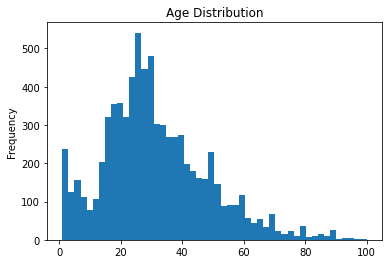

In [14]:
df_faces['real_age'].plot(kind='hist', bins=50)
plt.title('Age Distribution')

* Observations:
1. The histogram above shows right-skewed peaking at around age 24. Mostly, the ages are accumulated approximately between 20 to 40 years old.


In [15]:
#Plotting the Images
def plot_images(df, path, num=10, is_generator=False, img_datagen=None):
    plt.figure(figsize=(10, 10))
    if not is_generator:
        sample_faces = df['file_name'].sample(n=num)
    else:
        sample_faces, _ = img_datagen
        sample_faces = sample_faces[:num]
    for idx, file in enumerate(sample_faces):
        plt.subplot(2, 5, idx+1)
        
        if not is_generator:
            img = Image.open(os.path.join(path, file))
            plt.imshow(np.array(img, dtype=np.uint8))
        
        else:
            img = file
            plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

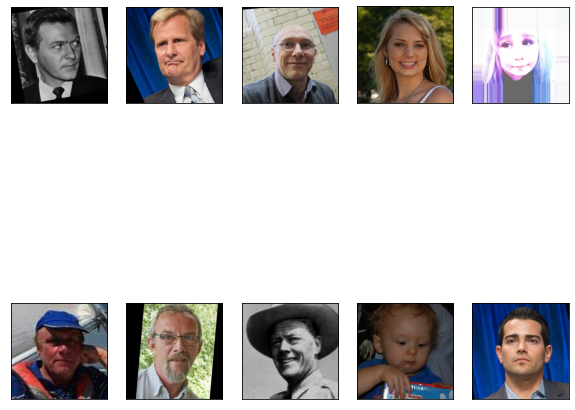

In [17]:
img_dir = r'/datasets/faces/final_files'
plot_images(df_faces, img_dir)

### Findings

1. Most of the images are straight and uncropped.
2. There are notable images and also ordinary ones. 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [19]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    
    df = pd.read_csv(path, 'labels.csv')
    img_dir = path + 'final_files/'
    
    train_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=.2,
                            zoom_range=0.2,
    )
    train_gen_flow = train_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=32,
                            class_mode='raw',
                            subset='training',
                            seed=42,
                            )

    return train_gen_flow

In [20]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    df = pd.read_csv(path, 'labels.csv')
    img_dir = path + 'final_files/'
    
    test_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
    )
    test_gen_flow = test_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=32,
                            class_mode='raw',
                            subset='validation',
                            seed=42,
                            )

    return test_gen_flow

In [21]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.00002)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [22]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [23]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

* Train for 380 steps, validate for 95 steps
* Epoch 1/5
* 380/380 - 67s - loss: 439.4274 - mae: 15.7631 - val_loss: 1090.9373 - val_mae: 28.3966
* Epoch 2/5
* 380/380 - 60s - loss: 109.5056 - mae: 7.9654 - val_loss: 159.9361 - val_mae: 9.5251
* Epoch 3/5
* 380/380 - 60s - loss: 78.1308 - mae: 6.8033 - val_loss: 92.9382 - val_mae: 7.2460
* Epoch 4/5
* 380/380 - 60s - loss: 62.7130 - mae: 6.1367 - val_loss: 85.3214 - val_mae: 6.9730
* Epoch 5/5
* 380/380 - 60s - loss: 51.3950 - mae: 5.5770 - val_loss: 88.1017 - val_mae: 6.9195


## Conclusions

- The initial model with a batch_size=32 and learning_rate=0.01 got a MAE of around 10 years.
- After removing the zooming operation, and reducing the batch_size=16, and removing the Dense layer of 128 neurons, and training for 5 epochs, we got an MAE of 6.9 years.